# Camera intrinsics, screen coordinates and 3D data.

At first, we install some dependencies.

Installing `face_api_dataset` from the github it it's not already installed.

In [1]:
%%bash

(python -c "import face_api_dataset")
if [ $? -eq 0 ]
then
    echo "face_api_dataset is already installed"
else
    echo "installing face_api_dataset from github"
    pip install git+https://github.com/Synthesis-AI-Dev/face_api_dataset.git
fi

installing face_api_dataset from github
  Cloning https://github.com/Synthesis-AI-Dev/face_api_dataset.git (to revision SAI-567) to /tmp/pip-req-build-4xsyy3p0
  Created wheel for face-api-dataset: filename=face_api_dataset-1.0.5-py3-none-any.whl size=12322 sha256=a4823d0131e197366133a40a480ccf8590cfc593f7ba684ebf26d18f5b667da7
  Stored in directory: /tmp/pip-ephem-wheel-cache-yn93f4lt/wheels/43/c6/34/659c6c7406c806e585363d4900df91af182db12586fadab0a5
Successfully built face-api-dataset
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'face_api_dataset'
  Running command git clone -q https://github.com/Synthesis-AI-Dev/face_api_dataset.git /tmp/pip-req-build-4xsyy3p0
  Running command git checkout -b SAI-567 --track origin/SAI-567
  Switched to a new branch 'SAI-567'
  Branch 'SAI-567' set up to track remote branch 'SAI-567' from 'origin'.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Installing `git lfs` from the github it it's not already installed.

In [2]:
%%bash

(git lfs install > /dev/null)
if [ $? -eq 0 ]
then
    echo "git lfs is already installed"
else
    echo "installing git lfs"
    case "$(uname -s)" in

       Darwin)
         brew install git-lfs
         ;;

       Linux)
         curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
         apt-get install git-lfs
         ;;

       *)
         echo "This cell can't install git lfs your OS. Please take care of it yourself."
         ;;
    esac
fi

installing git lfs
Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists...
Building dependency tree...
Reading state information...
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-libra

git: 'lfs' is not a git command. See 'git --help'.

The most similar command is
	log


Pulling the test dataset for the example

In [3]:
%%bash

if [ -d "../test_dataset" ]
then
    echo "test_dataset is already present"
else
    echo "downloading test_dataset"
    git clone https://github.com/Synthesis-AI-Dev/face_api_dataset
    mv face_api_dataset/test_dataset ..
    rm -rf face_api_dataset
fi

downloading test_dataset


Cloning into 'face_api_dataset'...
Filtering content: 100% (689/689), 290.97 MiB | 25.08 MiB/s, done.


Finally we add some imports for the visualisation.

In [4]:
import cv2
%matplotlib inline

In [5]:
import numpy as np

We use `FaceApiDataset` class to access synthesis datasets.


In [6]:
from face_api_dataset import FaceApiDataset, Modality

**Warning!** Some of modalities requires additional libraries to be installed:
`SEGMENTS` and `RGB` modalities use `opencv-python` library,
 while `DEPTH`, `ALPHA` and `NORMALS` modalities
 use `tiffile`  and `imagecodecs` libraries for effective work with floating point tiff files.
 If dataset with these modalities will be created without corresponding libraries present, an `ImportError` is raised.


In [7]:
data_root = "../test_dataset"
dataset = FaceApiDataset(data_root,
                        modalities=[Modality.RGB, Modality.CAM_INTRINSICS, Modality.LANDMARKS_3D_IBUG68,
                                    Modality.LANDMARKS_IBUG68, Modality.DEPTH,
                                    Modality.LANDMARKS_DENSE_MEDIAPIPE, Modality.LANDMARKS_DENSE_SAI
                                   ])

In [8]:
len(dataset)

86

There are 13 items in the test dataset. Let's explore them closer.

In [9]:
item = dataset[0]
item2 = dataset[1]

Each item is a dict with different modalities as keys.

In [10]:
print(item.keys())

dict_keys([<Modality.RGB: 2>, <Modality.DEPTH: 4>, <Modality.LANDMARKS_IBUG68: 7>, <Modality.LANDMARKS_3D_IBUG68: 13>, <Modality.CAM_INTRINSICS: 33>, <Modality.LANDMARKS_DENSE_MEDIAPIPE: 36>, <Modality.LANDMARKS_DENSE_SAI: 37>])


In this notebook we explore camera intrinsics and transistion between 3D and the screen coordinate systems.

In [11]:
intrinsics = item[Modality.CAM_INTRINSICS]
intrinsics

array([[3.1030303e+03, 0.0000000e+00, 5.1200000e+02],
       [0.0000000e+00, 3.1030303e+03, 5.1200000e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

The camera intrinsics are in OpenCV format:
$$\left [ \begin{matrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{matrix} \right ]$$,
where $f_x$ and $f_y$ are focal distances and $c_x$ and $c_y$ is an optical center
(2D coordinates of the point, camera is pointing at on the image).

Note, that units of distance in 3D are meters and units in 2D are pixels, the conversion coefficient is already included in $f_x$.

$c_x$ and $c_y$ are usually equal to the half of the image resolution as camera is normally pointing to the center of the image.

In [12]:
np.array(item[Modality.RGB].shape[:2]) / 2

array([512., 512.])

Now we can convert between camera and screen coordinate systems. Let's see how it is done, using ibug68 landmarks.

In [13]:
landmark_0 = item[Modality.LANDMARKS_3D_IBUG68][0]
landmark_0

(-0.06828872114419937, -0.013793110847473145, -1.0131522417068481)

At first, we need to check that landmark is in front of the camera (z coordinate is negative):

In [14]:
landmark_0[2] < 0


True

Now we can convert to screen coordinate system, using intrinsic matrix. However, our 3D camera coordinate system uses OpenGL axis (x right, y top, z towards the camera), and OpenCV system uses a different [one](https://docs.opencv.org/4.5.3/d9/d0c/group__calib3d.html) (x right, y bottom, z from the camera).
Thus before we apply the conversion, we need to convert between this coordinate systems, otherwise screen coordinates will be mirrored vertically.

In [15]:
def opengl_to_opencv(x):
    return np.array(x) * [1, -1, -1]

To compute landmark in screen coordinates we need to multiply 3D coordinates by the intrinsic matrix.

In [16]:
def cam_to_hom_screen(intrinsics, x):
    return np.tensordot(opengl_to_opencv(x), intrinsics, axes=(-1, 1))

In [17]:
cam_to_hom_screen(intrinsics, landmark_0)

array([306.83197669, 561.53438869,   1.01315224])

We get the result, but it is in homogeneous coordinates. We need to convert it to euclidian.

In [18]:
def from_homogeneous_2D(xs):
    xs_array = np.array(xs)
    assert (xs_array.shape[-1] == 3)

    slice_but_last = [slice(None)] * (xs_array.ndim - 1) + [slice(None, -1)]
    slice_but_last = tuple(slice_but_last)

    slice_last = [slice(None)] * (xs_array.ndim - 1) + [slice(-1, None)]
    slice_last = tuple(slice_last)
    return xs_array[slice_but_last] / xs_array[slice_last]

In [19]:
def cam_to_screen(intrinsics, x):
    return from_homogeneous_2D(cam_to_hom_screen(intrinsics, x))


In [20]:
cam_to_screen(intrinsics, landmark_0)

array([302.8488356 , 554.24482676])

To check ourselves, let's compare with 2D location of this landmark we get from the info.json:

In [22]:
item[Modality.LANDMARKS_IBUG68][0]

(302.8992, 554.2912)

Now let's have a look, how landmarks look in 3D.

We use ploply to visualise 3D data.

In [23]:
import plotly.express as px
import plotly.graph_objects as go

import pandas as pd

In [25]:
x, y, z =  np.array(list(item[Modality.LANDMARKS_3D_IBUG68].values()), dtype=np.float64).transpose()
lid = list(item[Modality.LANDMARKS_3D_IBUG68].keys())

Let's visualize landmarks with labels:

In [26]:
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, text=lid, mode='markers+text', marker={"size": 2})])
fig.update_layout(scene_camera={"eye": {"x": 0., "y": 0., "z": 2},
                                "up": {"x": 0, "y": 1, "z": 0}}, title="iBUG68 3D labeled")
fig.show()

And without them for more clarity:

In [27]:
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers+text', marker={"size": 2})])
fig.update_layout(scene_camera={"eye": {"x": 0., "y": 0., "z": 2},
                                "up": {"x": 0, "y": 1, "z": 0}}, title="iBUG68 3D")
fig.show()

Now we can project all the landmarks to the screen and check that position is correct on the image as well:

In [28]:
import matplotlib.pyplot as plt

In [29]:
def landmark_show(img, landmarks, radius=2, labels=True):
    l_img = np.copy(img)
    for x, y in landmarks:
        int_p = (int(x), int(y))
        cv2.circle(l_img, int_p, radius=radius, color=(255, 0, 0), thickness=cv2.FILLED)
    plt.imshow(l_img)

In [30]:
landmarks_2D = cam_to_screen(intrinsics, np.array(list(item[Modality.LANDMARKS_3D_IBUG68].values()), dtype=np.float64))

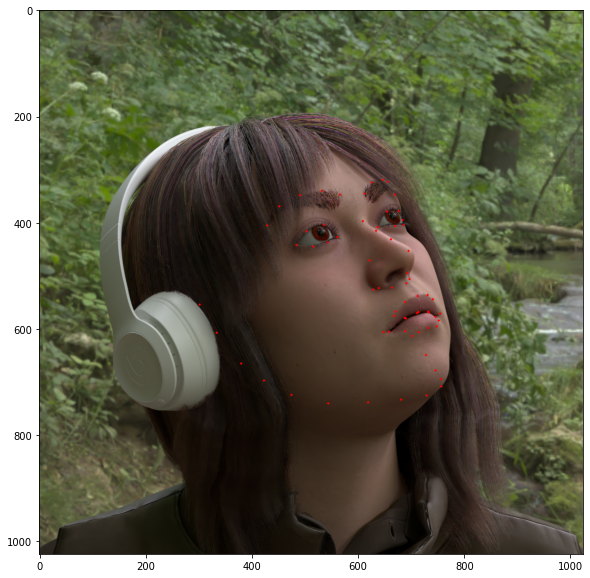

In [42]:
plt.figure(figsize=(10,10))
landmark_show(item[Modality.RGB], landmarks_2D)

From intrinsic transform we can compute reverse intrinsic transform, which is needed to map points from the image to 3D space.

In [32]:
rev_intrinsics = np.linalg.inv(intrinsics)

Screen coordinates are equivealent to the pixel position:

In [33]:
shape = item[Modality.RGB].shape
screen_xs, screen_ys = np.meshgrid(np.linspace(0, shape[1] - 1, shape[1]),
                                   np.linspace(0, shape[0] - 1, shape[0]))
depth = item[Modality.DEPTH]
color = item[Modality.RGB]

To apply reverse projection we need to homogenize the coordinates and multiply them by reversed intrinsic matrix:

In [34]:
xs, ys, zs = np.moveaxis(np.tensordot(np.stack([screen_xs * depth, screen_ys * depth, depth]), rev_intrinsics, axes=(0, 1)), -1, 0) * np.array([1,-1,-1]).reshape(-1, 1, 1)

Now we can show point cloud of the head.

In [43]:
fig = go.Figure(data=[go.Scatter3d(x=xs[zs<0], y=ys[zs<0], z=zs[zs<0],
                                   mode='markers+text', marker={"size": 1, "color": color[zs<0]})])
fig.update_layout(scene_camera={"eye": {"x": 0., "y": 0., "z": 2},
                                "up": {"x": 0, "y": 1, "z": 0}}, title="Head 3D reconstruction")
fig.show()


To check that everything is correct let's display landmarks at the same 3D plot as well:

In [39]:
x, y, z =  np.array(list(item[Modality.LANDMARKS_3D_IBUG68].values()), dtype=np.float64).transpose()

fig = go.Figure(data=[go.Scatter3d(x=xs[zs<0], y=ys[zs<0], z=zs[zs<0],
                                   mode='markers+text', marker={"size": 1, "color": color[zs<0]}),
                      go.Scatter3d(x=x, y=y, z=z, mode='markers+text', marker={"size": 3})])
fig.update_layout(scene_camera={"eye": {"x": 0., "y": 0., "z": 2},
                                "up": {"x": 0, "y": 1, "z": 0}}, title="Head 3D reconstruction with landmarks",
                  showlegend=False)
fig.show()


Let't consider dense landmarks. There are 2 types of them: Modality.LANDMARKS_DENSE_MEDIAPIPE, Modality.LANDMARKS_DENSE_SAI.

In [45]:
item = dataset[0]
lm_dense_mediapipe = item[Modality.LANDMARKS_DENSE_MEDIAPIPE]
lm_dense_sai = item[Modality.LANDMARKS_DENSE_SAI]
print(f"Shapes are: {lm_dense_mediapipe.shape} and {lm_dense_sai.shape}")

Shapes are: (468, 3) and (4840, 3)


Both types are in camera coordinate sysmet, so we can draw them as previous 3d_IBUG landmarks.


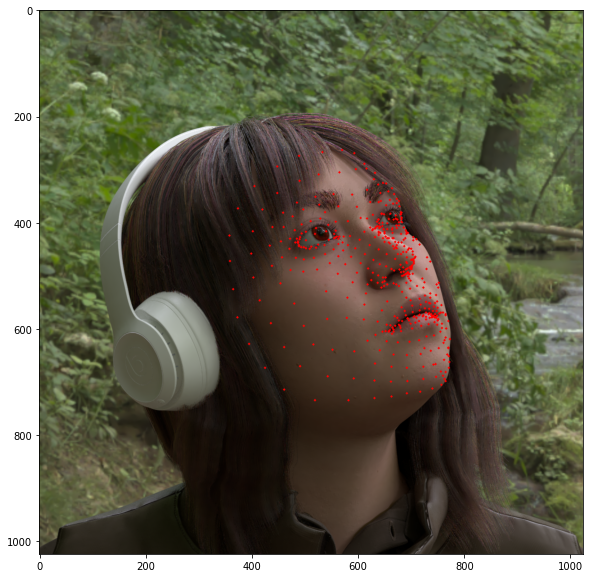

In [48]:
plt.figure(figsize=(10,10))
landmark_show(item[Modality.RGB], cam_to_screen(intrinsics, lm_dense_mediapipe))


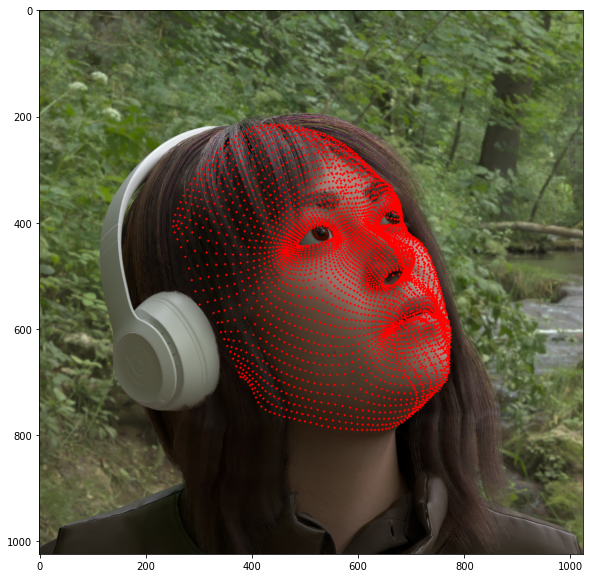

In [49]:
plt.figure(figsize=(10,10))
landmark_show(item[Modality.RGB], cam_to_screen(intrinsics, lm_dense_sai))


In [50]:
x,y,z = lm_dense_mediapipe.transpose()
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers+text', marker={"size": 2})])
fig.update_layout(scene_camera={"eye": {"x": 0., "y": 0., "z": 2},
                                "up": {"x": 0, "y": 1, "z": 0}}, title="DENSE_MEDIAPIPE")
fig.show()

In [51]:
x,y,z = lm_dense_sai.transpose()
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers+text', marker={"size": 2})])
fig.update_layout(scene_camera={"eye": {"x": 0., "y": 0., "z": 2},
                                "up": {"x": 0, "y": 1, "z": 0}}, title="DENSE_SAI")
fig.show()